# 1. Classification

In [1]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import *
from sklearn.metrics import *


In [2]:
def plot_all(X_test, y_test, all_clfs, clf_names):
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    roc_scores = plot_roc_curve(X_test, y_test, all_clfs, clf_names)
    plt.subplot(122)
    pr_scores = plot_pr_curve(X_test, y_test, all_clfs, clf_names)
    plt.savefig(image_path+file.split('.')[0]+'-roc_pr')
    plt.show()
    return roc_scores, pr_scores

In [3]:
#plot tools
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]

    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes 
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            roc_scores[clf_name] = roc_auc
            plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')         
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)

            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i],y_score[:,i])
                roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(),y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            
            roc_scores[clf_name] = roc_auc["micro"]
            plt.plot(fpr["micro"], tpr["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,roc_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')        
#     plt.savefig(image_path+file.split('.')[0]+'_roc')
#     plt.show()
    return roc_scores

def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]
    
    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
            pr_auc = sklearn.metrics.auc(recall, precision)
            pr_scores[clf_name] = pr_auc
            plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)

            # Compute ROC curve and ROC area for each class
            precision = dict()
            recall = dict()
            pr_auc = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:,i],y_score[:,i])
                pr_auc[i] = sklearn.metrics.auc(recall[i], precision[i])

            # Compute micro-average ROC curve and ROC area
            precision["micro"], recall["micro"], _ = sklearn.metrics.precision_recall_curve(y_test.ravel(),
                                                                                            y_score.ravel())
            pr_auc["micro"] = sklearn.metrics.auc(recall["micro"], precision["micro"])
            
            pr_scores[clf_name] = pr_auc["micro"]
            plt.plot(recall["micro"], precision["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,pr_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
#     plt.savefig(image_path+file.split('.')[0]+'_pr')
#     plt.show()
    return pr_scores

In [4]:
# classifiers
def train_KNN(X_train, y_train):
    print('Training KNN ...')
    knn = KNeighborsClassifier()
#     scoring = ['roc_auc']
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_SVM(X_train, y_train):
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_    

def train_LogisticRegression(X_train, y_train):
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_GaussianNaiveBayes(X_train, y_train):
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
#     scoring = ['roc_auc']
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPClassifier(solver='adam', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'hidden_layer_sizes' : [(100,50,10)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

In [5]:
#data processiong tools
def encode_labels(x_train, x_test, cols=None):
    label_encoder = sklearn.preprocessing.LabelEncoder()
    if cols == None:
        for i,t in enumerate(x_train.dtypes):
            if t == 'object':
                label_encoder.fit(df.iloc[:,i])
                x_train.iloc[:,i] = label_encoder.transform(x_train.iloc[:,i])
                x_test.iloc[:,i] = label_encoder.transform(x_test.iloc[:,i])   
    else:#only encode last col
        x_train.iloc[:] = label_encoder.fit_transform(x_train.iloc[:])
        x_test.iloc[:] = label_encoder.transform(x_test.iloc[:])
    return x_train, x_test

#put class colunmn at end of dataframe
def reorder_columns(dataFrame):
    cols = dataFrame.columns.tolist()
    cols = cols[1:] + cols[:1]
    return dataFrame[cols]

#impute ? with given strategy
def impute_value(x_train, x_test, strategy):
    try:
        x_train = x_train.replace({'?' : np.nan})
        x_test = x_test.replace({'?' : np.nan})
    except:
        print('no question mark found')
    if strategy == None:
        return x_train.dropna(), x_test.dropna()
    else:
        imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
        train_type_dic = dict()#keep original train data type before impute
        for i,t in enumerate(x_train.dtypes):
            if t != 'object':
                train_type_dic[i] = t
        test_type_dic = dict()#keep original test data type before impute
        for i,t in enumerate(x_test.dtypes):
            if t != 'object':
                test_type_dic[i] = t        
        x_train = pd.DataFrame(imp.fit_transform(x_train))
        x_test = pd.DataFrame(imp.transform(x_test))
        for key in train_type_dic:
            x_train.iloc[:,key] = x_train.iloc[:,key].astype(train_type_dic[key])
        for key in test_type_dic:
            x_test.iloc[:,key] = x_test.iloc[:,key].astype(test_type_dic[key])
        return x_train, x_test

In [6]:
#data sets
data_path = 'dataset/'
image_path = 'image/'

file1 = 'messidor_features.arff'
data1 = arff.loadarff(data_path+file1)
df1 = pd.DataFrame(data1[0])
# df1 = encode_labels(df1)

file2 = 'default of credit card clients.xls'
df2 = pd.read_excel(data_path+file2,index_col=0,header=1)
df2 = df2.sample(5000,random_state=0)

file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv(data_path+file3,header=None, index_col=0)
df3 = df3[df3[6]!='?'].astype('int64')
# df3 = encode_labels(df3, [-1])

file3_2 = 'wdbc.data'
df3_2 = pd.read_csv(data_path+file3_2,header=None, index_col=0)
df3_2 = reorder_columns(df3_2)
# df3_2 = encode_labels(df3_2)

file3_3 = 'wpbc.data'
df3_3 = pd.read_csv(data_path+file3_3,header=None, index_col=0)
df3_3 = reorder_columns(df3_3)
df3_3 = df3_3[df3_3[34]!='?']
df3_3[34] = df3_3[34].astype('int64')
# df3_3 = encode_labels(df3_3)

file4 = 'australian.dat'
df4 = pd.read_csv(data_path+file4,header=None,sep=' ')
df4 = reorder_columns(df4)

file5 = 'german.data-numeric'
df5 = pd.read_csv(data_path+file5,header=None,sep=' +', engine='python')
# df5 = encode_labels(df5, [-1])

#multi-class
file6 = 'Faults.NNA'
df6 = pd.read_csv(data_path+file6,header=None,sep='\t', engine='python')
cats  = df6.iloc[:,-7:].idxmax(axis=1)
df6 = pd.concat([df6.iloc[:,:-7],cats],axis=1)
# df6 = encode_labels(df6, [-1])

file7 = 'adult.data'
file7_test = 'adult.test'
df7 = pd.read_csv(data_path+file7,header=None,sep=', ', engine='python')
df7 = df7.sample(5000, random_state=0)
df7_test = pd.read_csv(data_path+file7_test,header=1,sep=', ', engine='python')
df7_test = None
# df7 = impute_value(df7, 'most_frequent')
# df7 = encode_labels(df7)

#multi-class
file8 = 'yeast.data'
df8 = pd.read_csv(data_path+file8,header=None,sep=' +', index_col=0, engine='python')
# df8 = encode_labels(df8)

#error dataset
file9 = 'ThoraricSurgery.arff'
data9 = arff.loadarff(data_path+file9)
df9 = pd.DataFrame(data9[0])
# d9 = encode_labels(df9)

file10 = 'seismic-bumps.arff'
data10, meta = arff.loadarff(data_path+file10)
df10 = pd.DataFrame(data10)
# df10 = encode_labels(df10)

In [7]:
def run_all_clfs(X_train, y_train, X_test, y_test):
    all_clfs = []
    clf_names = []

    clf1 = train_KNN(X_train, y_train)
    all_clfs.append(clf1)
    clf_names.append('KNN')

    clf2 = train_SVM(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('SVM')

    clf3 = train_DecisionTree(X_train, y_train)
    all_clfs.append(clf3)
    clf_names.append('Decision Tree')

    clf4 = train_RandomForest(X_train, y_train)
    all_clfs.append(clf4)
    clf_names.append('Random Forest')

    clf5 = train_AdaBoost(X_train, y_train)
    all_clfs.append(clf5)
    clf_names.append('AdaBoost')

    clf6 = train_LogisticRegression(X_train, y_train)
    all_clfs.append(clf6)
    clf_names.append('Logistic regression')

    clf7 = train_GaussianNaiveBayes(X_train, y_train)
    all_clfs.append(clf7)
    clf_names.append('Gaussian Naive Bayes')

    clf8 = train_NeuralNetwork(X_train, y_train)
    all_clfs.append(clf8)
    clf_names.append('NeuralNetwork')

    return all_clfs, clf_names

In [8]:
def make_classification(file, df, df_test):
    print("Dataset : %s" % file)
    #     df.info()
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    assert len(y.shape) == 1, "wrong shape of y"
    
    if type(df_test) == type(None):
        print('No default test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded given test set')
        X_train = X
        y_train = y
        df_test = replace_question_marks(df_test)
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]      
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    X_train, X_test = impute_value(X_train, X_test, strategy='most_frequent')
    X_train, X_test = encode_labels(X_train, X_test)
#     y_train, y_test = impute_value(y_train, y_test, strategy='most_frequent')
    y_train, y_test = encode_labels(y_train, y_test, -1)
#     scaler = preprocessing.StandardScaler().fit(X_train)
    scaler = preprocessing.MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    all_clfs, clf_names = run_all_clfs(X_train, y_train, X_test, y_test)
    roc_scores, pr_scores = plot_all(X_test, y_test, all_clfs, clf_names)
    return roc_scores, pr_scores

Dataset : messidor_features.arff
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


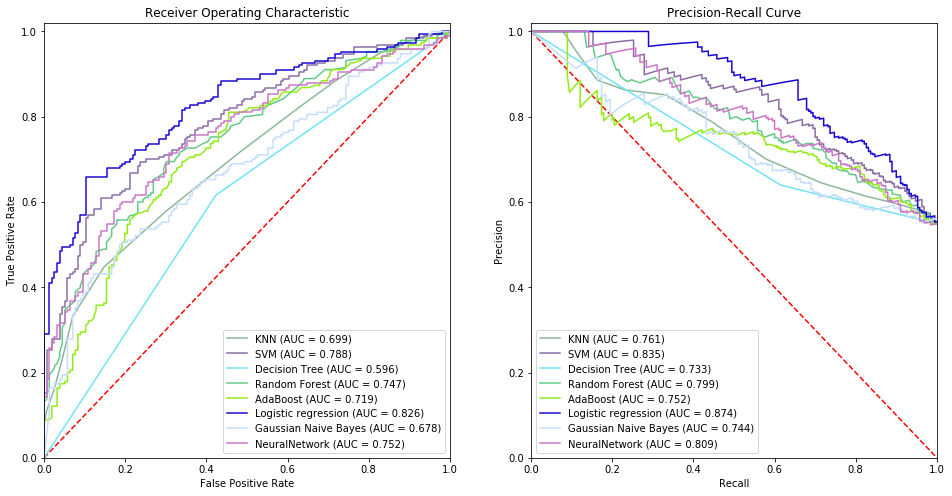

Dataset : default of credit card clients.xls
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


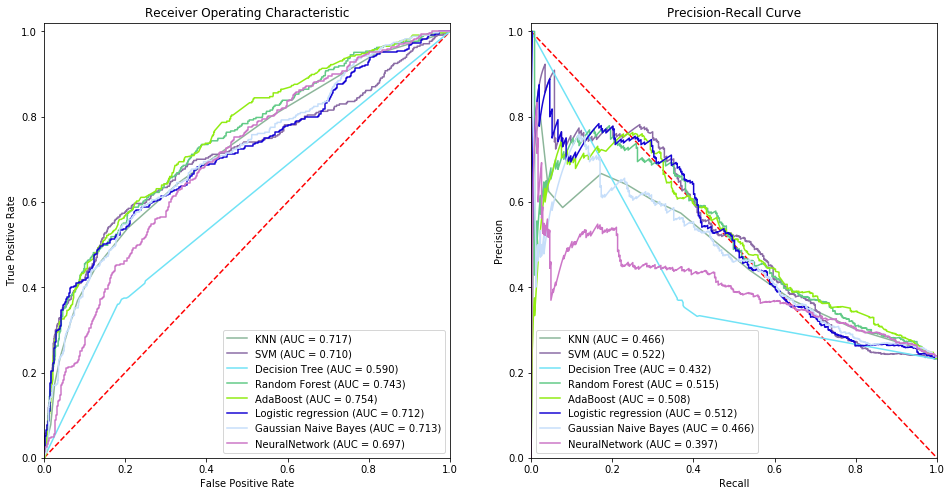

Dataset : breast-cancer-wisconsin.data
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


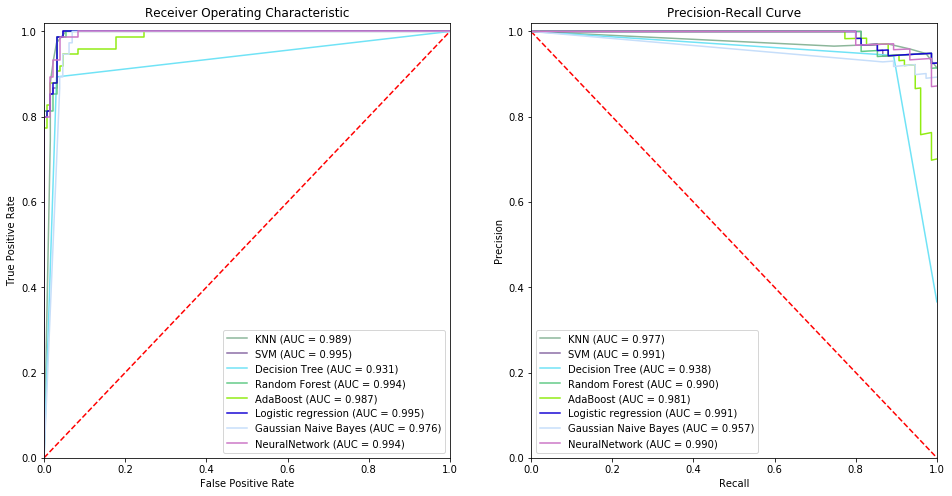

Dataset : wdbc.data
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (315) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


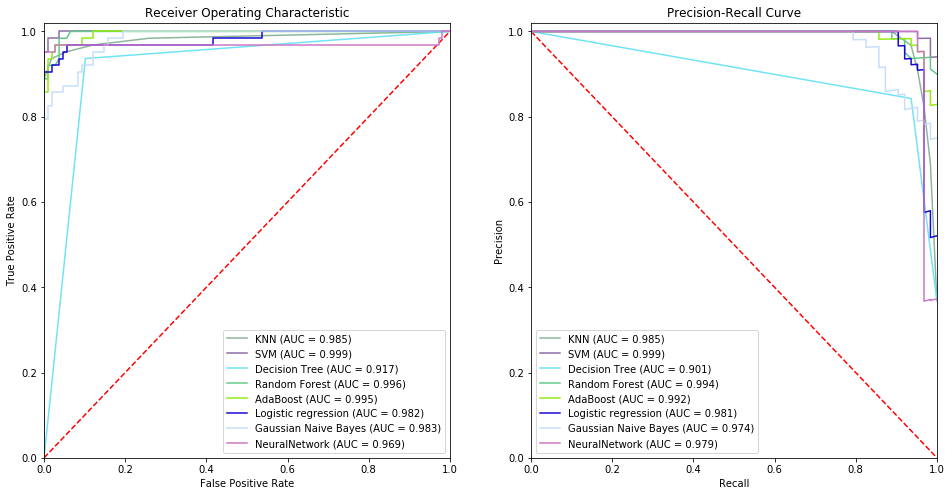

Dataset : wpbc.data
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


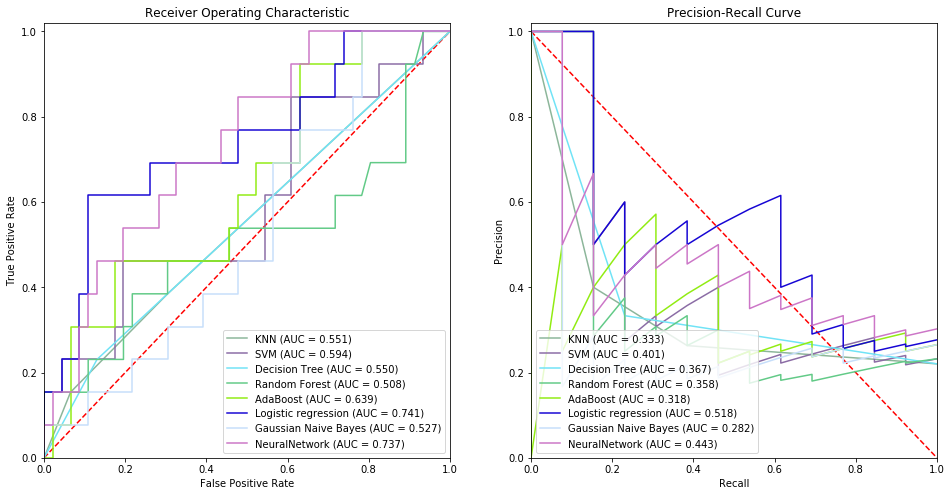

Dataset : australian.dat
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (315) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


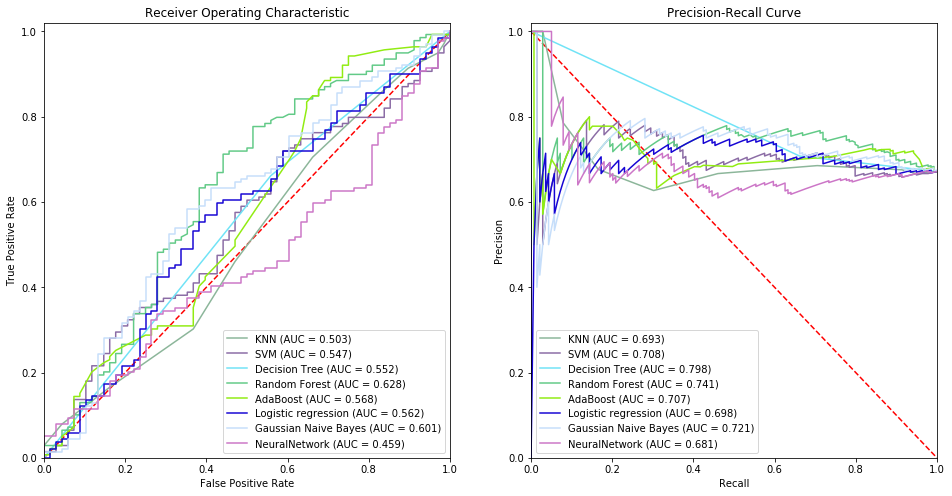

Dataset : german.data-numeric
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


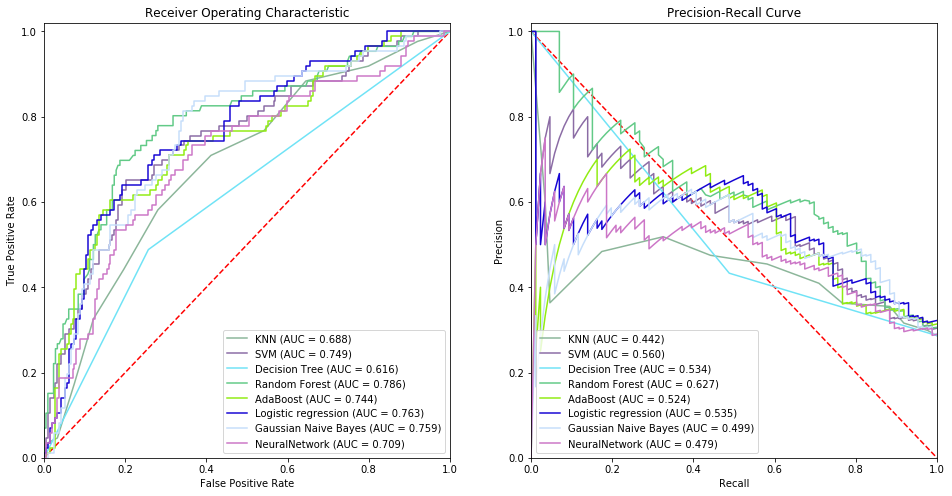

Dataset : Faults.NNA
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


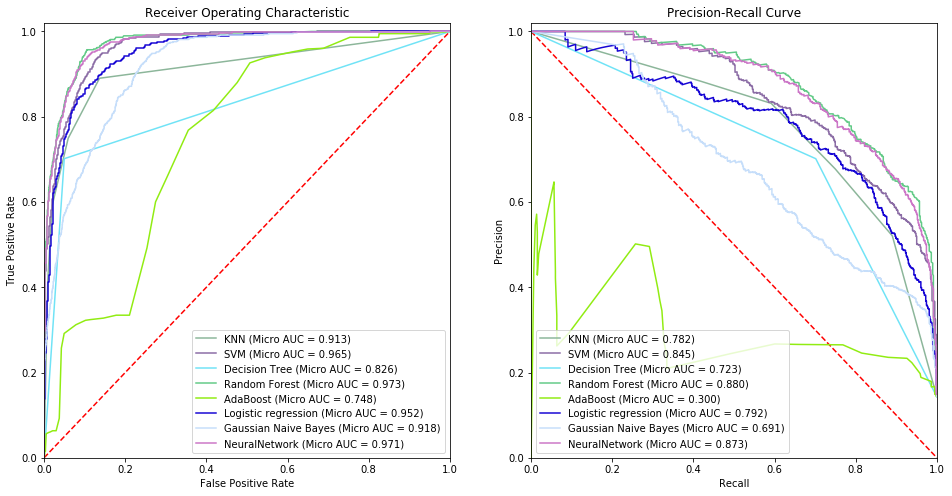

Dataset : adult.data
No default test set, dataset splitted
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (315) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


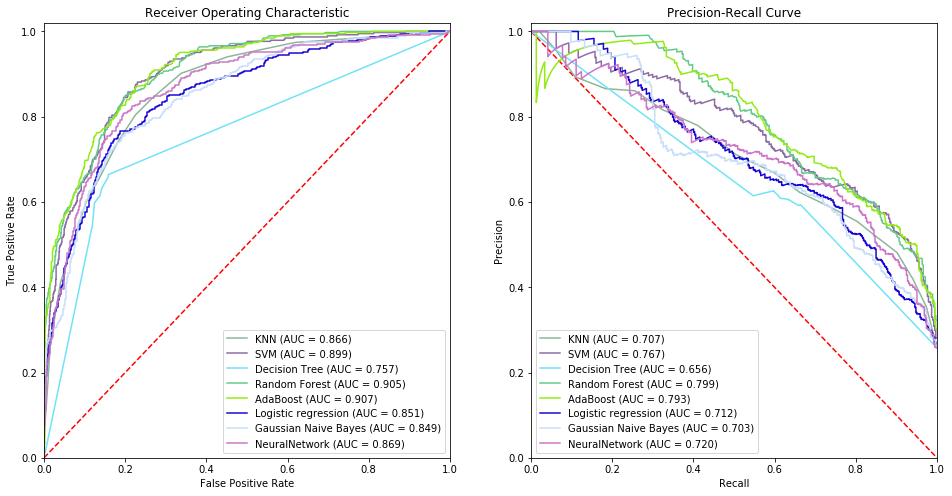

Dataset : yeast.data
No default test set, dataset splitted
no question mark found
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


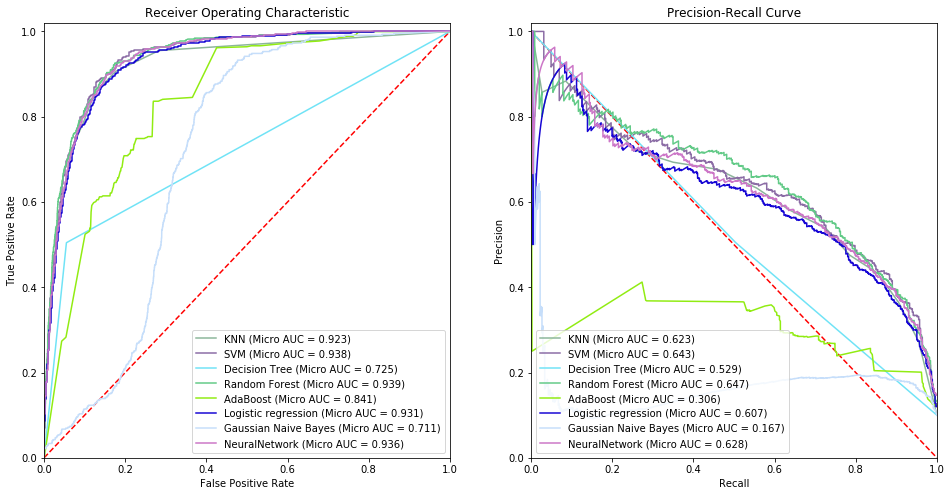

Dataset : ThoraricSurgery.arff
No default test set, dataset splitted
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


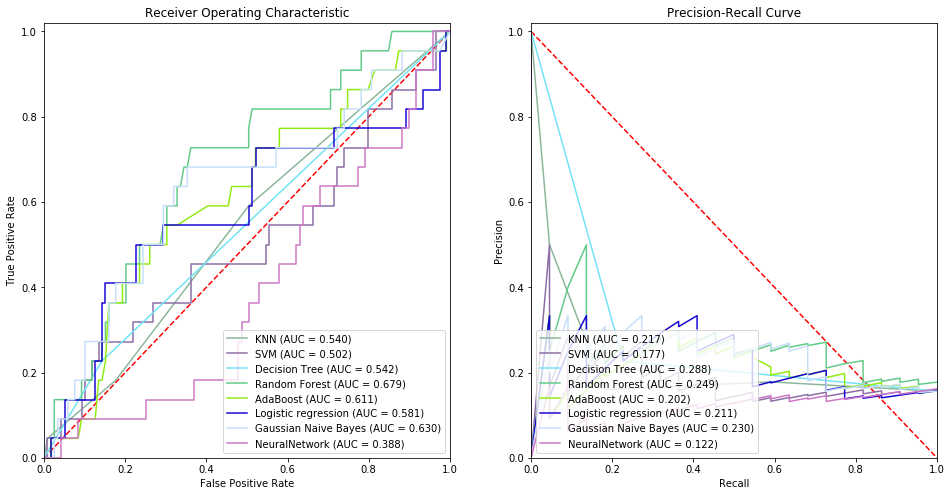

Dataset : seismic-bumps.arff
No default test set, dataset splitted
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training LogisticRegression ...
Training GaussianNaiveBayes ...
Training NeuralNetwork ...


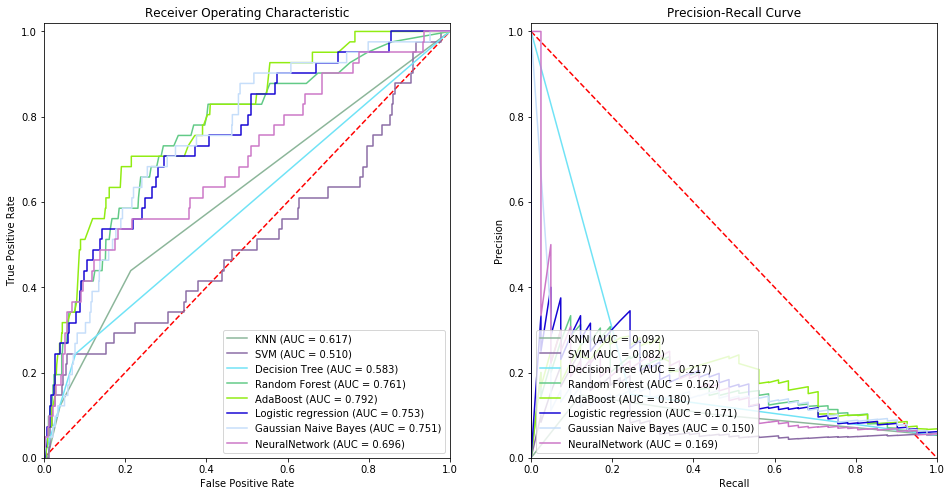

In [9]:
# %%time
files = [file1,file2,file3,file3_2,file3_3,file4,file5,file6,file7,file8,file9,file10]
dfs = [df1,df2,df3,df3_2,df3_3,df4,df5,df6,df7,df8,df9,df10]
dfs_test = [None,None,None,None,None,None,None,None,df7_test,None,None,None]

clfs_all_roc_scores = dict()
clfs_all_pr_scores = dict()


for file,df,df_test in zip(files,dfs,dfs_test):
    roc_scores, pr_scores = make_classification(file, df, df_test)
    for k,v in roc_scores.items():
        if k not in clfs_all_roc_scores:
            clfs_all_roc_scores[k] = list()
        clfs_all_roc_scores[k].append(v)
    for k,v in pr_scores.items():
        if k not in clfs_all_pr_scores:
            clfs_all_pr_scores[k] = list()
        clfs_all_pr_scores[k].append(v)    

In [10]:
for k,v in clfs_all_roc_scores.items():
    print('%s-roc:'%k,["%.3f"%i for i in v])

KNN-roc: ['0.699', '0.717', '0.989', '0.985', '0.551', '0.503', '0.688', '0.913', '0.866', '0.923', '0.540', '0.617']
SVM-roc: ['0.788', '0.710', '0.995', '0.999', '0.594', '0.547', '0.749', '0.965', '0.899', '0.938', '0.502', '0.510']
Decision Tree-roc: ['0.596', '0.590', '0.931', '0.917', '0.550', '0.552', '0.616', '0.826', '0.757', '0.725', '0.542', '0.583']
Random Forest-roc: ['0.747', '0.743', '0.994', '0.996', '0.508', '0.628', '0.786', '0.973', '0.905', '0.939', '0.679', '0.761']
AdaBoost-roc: ['0.719', '0.754', '0.987', '0.995', '0.639', '0.568', '0.744', '0.748', '0.907', '0.841', '0.611', '0.792']
Logistic regression-roc: ['0.826', '0.712', '0.995', '0.982', '0.741', '0.562', '0.763', '0.952', '0.851', '0.931', '0.581', '0.753']
Gaussian Naive Bayes-roc: ['0.678', '0.713', '0.976', '0.983', '0.527', '0.601', '0.759', '0.918', '0.849', '0.711', '0.630', '0.751']
NeuralNetwork-roc: ['0.752', '0.697', '0.994', '0.969', '0.737', '0.459', '0.709', '0.971', '0.869', '0.936', '0.388

In [11]:
for k,v in clfs_all_roc_scores.items():
    print('%s avg roc_auc: %.2f, avg pr_auc: %.2f'%(k,np.mean(v),np.mean(clfs_all_pr_scores[k])))

KNN avg roc_auc: 0.75, avg pr_auc: 0.59
SVM avg roc_auc: 0.77, avg pr_auc: 0.63
Decision Tree avg roc_auc: 0.68, avg pr_auc: 0.59
Random Forest avg roc_auc: 0.81, avg pr_auc: 0.65
AdaBoost avg roc_auc: 0.78, avg pr_auc: 0.55
Logistic regression avg roc_auc: 0.80, avg pr_auc: 0.63
Gaussian Naive Bayes avg roc_auc: 0.76, avg pr_auc: 0.55
NeuralNetwork avg roc_auc: 0.76, avg pr_auc: 0.61
